In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
# Load train data (TODO: try out PCA)
train = None
labels = None
for i in range(1,6):
    batch = unpickle("cifar-10-batches-py/data_batch_{}".format(i))
    if train is None:
        train = batch[b'data'].astype(np.float32)/255.0
        labels = batch[b'labels']
    else:
        train = np.concatenate((train, \
            batch[b'data'].astype(np.float32)/255.0), axis = 0)
        labels.extend(batch[b'labels'])
        
train_data = train
train_labels = np.array(labels).reshape((-1,1))

# Load test data
test = unpickle("cifar-10-batches-py/test_batch")
test_data = test[b'data']
test_labels = np.array(test[b'labels']).reshape((-1,1))



In [4]:
def euclidian(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

In [3]:
def kMeans(X, K, maxIters = 20):

    centroids = X[np.random.choice(len(X), K)]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([(x_i-y_k)@(x_i-y_k) for y_k in centroids]) for x_i in X])
        # Update centroids step 
        centroids = []
        for k in range(K):
            if (C == k).any():
                centroids.append( X[C == k].mean(axis = 0) )
            else: # if there are no data points assigned to this certain centroid
                centroids.append( X[np.random.choice(len(X))] )
    return np.array(centroids) , C

centroids, C = kMeans(train_data, 10, 20)
print(centroids)
print(C)

[[0.5806848  0.5771131  0.5804343  ... 0.6974163  0.6953034  0.69499004]
 [0.4512627  0.4503183  0.45439327 ... 0.36215624 0.36532533 0.3710607 ]
 [0.844579   0.83945966 0.84127104 ... 0.8311395  0.8320222  0.8369339 ]
 ...
 [0.2950833  0.29304308 0.29501256 ... 0.36454725 0.36153165 0.35960355]
 [0.29696503 0.29319298 0.29371226 ... 0.52512753 0.51990044 0.51513034]
 [0.46239686 0.46001098 0.46560976 ... 0.3233252  0.32477325 0.3269678 ]]
[7 1 5 ... 5 6 5]


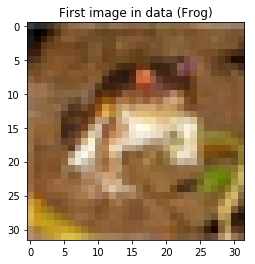

In [3]:
test_image = np.transpose(np.reshape(train_data[0], (-1, 3, 32, 32)), (0, 2, 3, 1))
plt.imshow(test_image[0])
plt.title("First image in data (Frog)")
plt.show()

In [4]:
inputs = np.transpose(np.reshape(centroids, (-1, 3, 32, 32)), (0, 2, 3, 1))

NameError: name 'centroids' is not defined

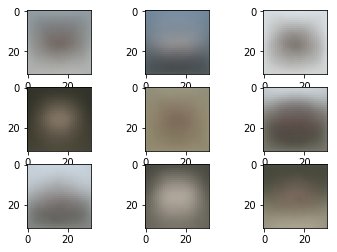

In [6]:
fig, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(inputs[i*3 + j])
plt.show()

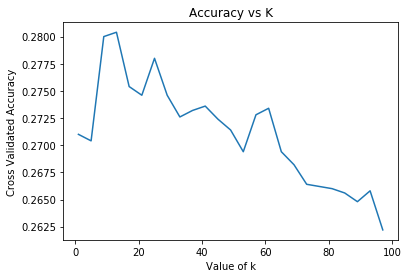

In [5]:


features = train_data[0:5000,:]
labels = train_labels[0:5000,:]

def getAccuracy(k, train_set, test_set, train_labels, test_labels):
    correct = 0
    total = 0
    for i in range(len(test_labels)):
        vec = test_set[i,:]
        indices = np.arange(len(train_set))
        sorted_indices = sorted(indices,  \
        key = lambda x: euclidian(train_set[x,:], vec))
        

        # Get overall prediction for k nearest neighbors
        neighbor_labels = []
        for j in range(k):
            neighbor_labels.append(train_labels[sorted_indices[j]][0])
        mode, count = stats.mode(np.array(neighbor_labels))
        if mode[0] == test_labels[i]:
            correct += 1
        total += 1

    return correct / total


final_accuracies = []
kvalues = list(range(1,100,4))
for k in kvalues:
    overall_accuracy = []
    subsetsize = len(labels) // 10
    for i in range(0,len(labels),subsetsize):
        test = features[i:i+subsetsize,:]
        test_labels = labels[i:i+subsetsize,:]
        train = np.concatenate((features[0:i, :], \
            features[i+subsetsize:,:]), axis=0)
        train_lbls = np.concatenate(\
            (labels[0:i, :],labels[i+subsetsize:,:]), axis=0)
        overall_accuracy.append(getAccuracy(k, \
            train, test, train_lbls, test_labels))
    final_accuracies.append(sum(overall_accuracy)/len(overall_accuracy))


plt.plot(kvalues, final_accuracies)
plt.title("Accuracy vs K")
plt.xlabel("Value of k")
plt.ylabel("Cross Validated Accuracy")
plt.show()

In [5]:
# https://stackoverflow.com/questions/51737245/how-to-sort-a-numpy-array-by-frequency
from collections import OrderedDict, Counter

class OrderedCounter(Counter, OrderedDict):
    pass


def get_top_k_accuracy(train, train_labels, test, test_labels, num_neighbors, k):
    correct = 0
    total = 0
    print(train.shape, test.shape, test_labels.shape)
    for i in range(len(test)):
        vec = test[i,:]
        indices = np.arange(len(train))
        sorted_indices = sorted(indices,  \
        key = lambda x: euclidian(train[x,:], vec))
        

        # Get overall prediction for k nearest neighbors
        neighbor_labels = []
        for j in range(num_neighbors):
            neighbor_labels.append(train_labels[sorted_indices[j]][0])
        c = OrderedCounter(neighbor_labels)
        keys = list(c)
        res = sorted(c, key=lambda x: (-c[x], keys.index(x)))
        if test_labels[i] in res[0:k]:
            correct += 1
        total += 1

    return correct / total

get_top_k_accuracy(train_data, train_labels, test_data, test_labels, 17, 3)

(50000, 3072) (10000, 3072) (10000, 1)


0.3133